In [1]:
# %load plot_compareZ.py
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from astropy import units as u
from astropy import constants as cst

from scipy.integrate import quad, quad_vec
import pyc2ray as pc2r
import scipy

2024-12-06 17:39:18.222530: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 17:39:18.249497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-06 17:39:18.249519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-06 17:39:18.250241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-06 17:39:18.254760: I tensorflow/core/platform/cpu_feature_guar

## Black Body SED class

In [9]:
from scipy.integrate import quad,quad_vec

h_over_k = (cst.h/cst.k_B).cgs.value
pi = np.pi
c = cst.c.cgs.value
two_pi_over_c_square = 2.0*pi/(c*c)
hplanck = cst.h.cgs.value
ion_freq_HI = (cst.Ryd * cst.c).cgs.value
sigma_0 = 6.3e-18

class BlackBodySource_Multifreq:
    """A point source emitting a Black-body spectrum
    """
    def __init__(self, temp, freq0_HI, freq0_HeI, freq0_HeII, grey) -> None:
        self.temp = temp
        self.grey = grey
        self.R_star = 1.0
        self.freq0_HI = freq0_HI
        self.freq0_HeI = freq0_HeI
        self.freq0_HeII = freq0_HeII
        
        self.freqs_tab, self.pl_index_HI, self.pl_index_HeI, self.pl_index_HeII = np.loadtxt(pc2r.__path__[0]+'/tables/multifreq/Verner1996_spectidx.txt', unpack=True)

    def SED(self,freq):
        if (freq*h_over_k/self.temp < 700.0):
            sed = 4*np.pi*self.R_star**2*two_pi_over_c_square*freq**2/(np.exp(freq*h_over_k/self.temp)-1.0)
        else:
            sed = 0.0
        return sed
    
    def integrate_SED(self,f1,f2):
        res = quad(self.SED,f1,f2)
        return res[0]
    
    def normalize_SED(self,f1,f2,S_star_ref):
        S_unscaled = self.integrate_SED(f1,f2)
        S_scaling = S_star_ref / S_unscaled
        self.R_star = np.sqrt(S_scaling) * self.R_star

    def cross_section_freq_dependence(self, freq):
        if self.grey:
            return 1.0  
        else:
            # MB: use the power-low index of the higher frequency bin (private conversation with Garrelt, Ilian and Sambit), i.e.: use the predominat cross section
            i = np.digitize(x=freq, bins=self.freqs_tab)-1
            freq0 = self.freqs_tab[i]
            if(freq < self.freq0_HeI):
                pl_index = np.interp(x=freq, xp=self.freqs_tab, fp=self.pl_index_HI)
            elif(freq < self.freq0_HeII and freq >= self.freq0_HeI):
                pl_index = np.interp(x=freq, xp=self.freqs_tab, fp=self.pl_index_HeI)
            elif(freq >= self.freq0_HeII):
                pl_index = np.interp(x=freq, xp=self.freqs_tab, fp=self.pl_index_HeII)
            return (freq/freq0)**(-pl_index)
    
    # C2Ray distinguishes between optically thin and thick cells, and calculates the rates differently for those two cases. See radiation_tables.F90, lines 345 -
    def _photo_thick_integrand_vec(self, freq, tau):
        itg = self.SED(freq) * np.exp(-tau*self.cross_section_freq_dependence(freq))
        # To avoid overflow in the exponential, check
        return np.where(tau*self.cross_section_freq_dependence(freq) < 700.0, itg, 0.0)
    
    def _photo_thin_integrand_vec(self, freq, tau):
        itg = self.SED(freq) * self.cross_section_freq_dependence(freq) * np.exp(-tau*self.cross_section_freq_dependence(freq))
        return np.where(tau*self.cross_section_freq_dependence(freq) < 700.0, itg, 0.0)
    
    def _heat_thick_integrand_vec(self, freq, tau, freq0_elem):
        photo_thick = self._photo_thick_integrand_vec(freq, tau)
        return hplanck * (freq - freq0_elem) * photo_thick
    
    def _heat_thin_integrand_vec(self, freq, tau, freq0_elem):
        photo_thin = self._photo_thin_integrand_vec(freq,tau)
        return hplanck * (freq - freq0_elem) * photo_thin
    
    def make_photo_table(self, tau, freq_min, freq_max, S_star_ref):
        self.normalize_SED(freq_min,freq_max,S_star_ref)

        integrand_thin = lambda f : self._photo_thin_integrand_vec(f, tau)
        integrand_thick = lambda f : self._photo_thick_integrand_vec(f, tau)

        # limit the frequency integration based on the provided limit
        freqs = self.freqs_tab

        # empty tables
        table_thin = np.zeros((tau.size, freqs.size))
        table_thick = np.zeros((tau.size, freqs.size))

        for i_f, (f_min, f_max) in enumerate(zip(freqs[:-1], freqs[1:])):
            table_thin[:, i_f] = quad_vec(integrand_thin, f_min, f_max, epsrel=1e-12)[0]
            table_thick[:, i_f] = quad_vec(integrand_thick, f_min, f_max, epsrel=1e-12)[0]
        
        # tables must have shapes: (num taus, num freq) due to the C++ order
        return table_thin.T, table_thick.T
    
    def make_heat_table(self, tau, freq_min, freq_max, freq0_elem, S_star_ref):
        self.normalize_SED(freq_min, freq_max, S_star_ref)
        
        integrand_thin = lambda f : self._heat_thin_integrand_vec(f, tau, freq0_elem)
        integrand_thick = lambda f : self._heat_thick_integrand_vec(f, tau, freq0_elem)
        
        # limit the frequency integration based on the provided limit
        freqs = self.freqs_tab

        # empty tables
        table_thin = np.zeros((tau.size, freqs.size))
        table_thick = np.zeros((tau.size, freqs.size))

        for i_f, (f_min, f_max) in enumerate(zip(freqs[:-1], freqs[1:])):
            table_thin[:, i_f] = quad_vec(integrand_thin, f_min, f_max, epsrel=1e-12)[0]
            table_thick[:, i_f] = quad_vec(integrand_thick, f_min, f_max, epsrel=1e-12)[0]

        # tables must have shapes: (num taus, num freq) due to the C++ order
        return table_thin.T, table_thick.T

## Calculate thick and think tables

In [23]:
from pyc2ray import make_tau_table

tau, dlogtau = make_tau_table(-20, 4, 2000)

freq_HI = (13.598*u.eV/cst.h).to('Hz').value
freq_HeII = (54.416*u.eV/cst.h).to('Hz').value

freq_max = freq_HeII
freq_min = freq_HI

freqs_tab, pl_index_HI, pl_index_HeI, pl_index_HeII = np.loadtxt(pc2r.__path__[0]+'/tables/multifreq/Verner1996_spectidx.txt', unpack=True)
freq_max = freqs_tab.max()
freq_min = freqs_tab.min()

In [24]:
freqs_mid = 0.5*(freqs_tab[1:]+freqs_tab[:-1])

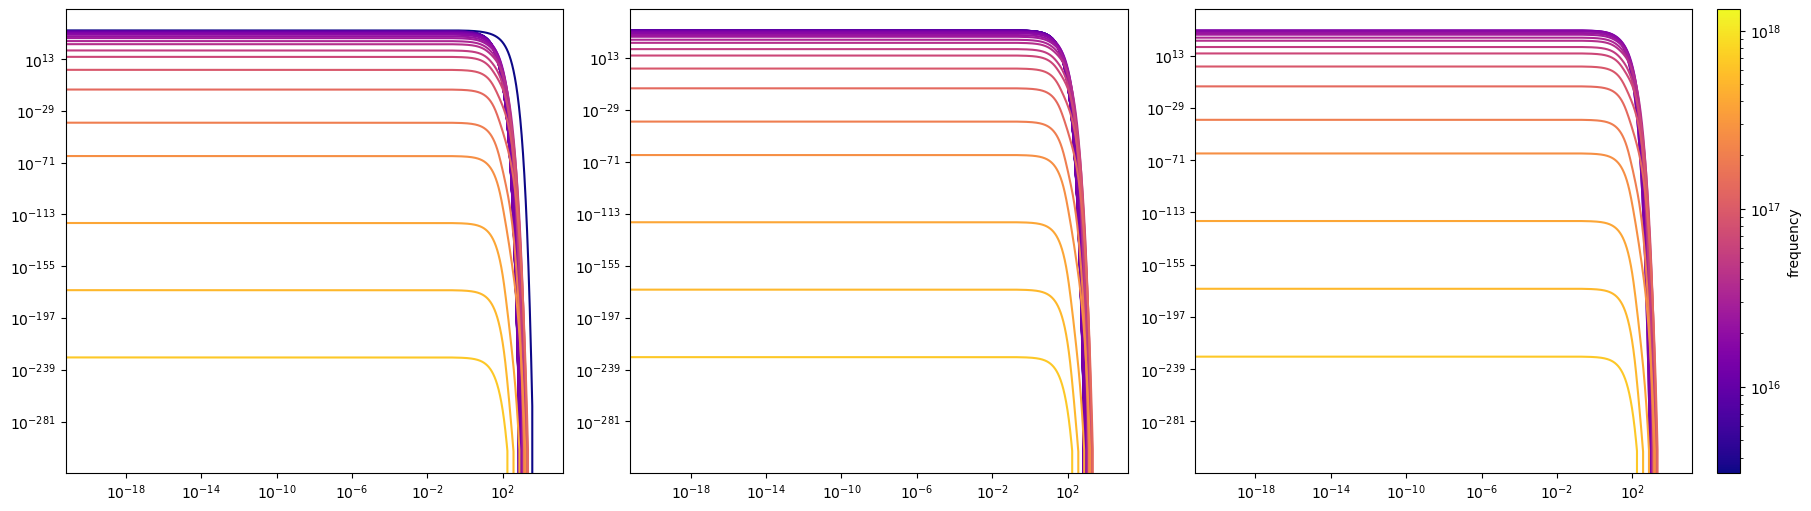

(None, None)

<Figure size 640x480 with 0 Axes>

In [38]:
freq0_HI = (13.598*u.eV/cst.h).to('Hz').value
freq0_HeI = (24.587*u.eV/cst.h).to('Hz').value
freq0_HeII = (54.416*u.eV/cst.h).to('Hz').value

r2 = BlackBodySource_Multifreq(temp=5e4, freq0_HI=freq0_HI, freq0_HeI=freq0_HeI, freq0_HeII=freq0_HeII, grey=False)

# photoionizing tables
photo_thin_table, photo_thick_table = r2.make_photo_table(tau, freq_min, freq_max, 1e48)

# photoheating tables
heat_thin_table_HI, heat_thick_table_HI = r2.make_heat_table(tau, freq_min, freq_max, freq0_HI, 1e48)
heat_thin_table_HeI, heat_thick_table_HeI = r2.make_heat_table(tau, freq_min, freq_max, freq0_HeI, 1e48)
heat_thin_table_HeII, heat_thick_table_HeII = r2.make_heat_table(tau, freq_min, freq_max, freq0_HeII, 1e48)

# create colorbar
norm = matplotlib.colors.LogNorm(vmin=freq_min, vmax=freq_max, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap='plasma')
sm = plt.cm.ScalarMappable(cmap=mapper.cmap, norm=norm)

# plot
fig, axs = plt.subplots(figsize=(18, 5), ncols=3, nrows=1, constrained_layout=True)
for i in range(photo_thick_table2.shape[0]):
    f = r2.freqs_tab[i]
    axs[0].loglog(tau, heat_thin_table_HI[i,:], color=mapper.to_rgba(f), ls='-')
    axs[1].loglog(tau, heat_thin_table_HeI[i,:], color=mapper.to_rgba(f), ls='-')
    axs[2].loglog(tau, heat_thin_table_HeII[i,:], color=mapper.to_rgba(f), ls='-')

cbar = plt.colorbar(sm, ax=axs[2], label='frequency')

plt.show(), plt.clf()

## Compare mono- with multi-frequency

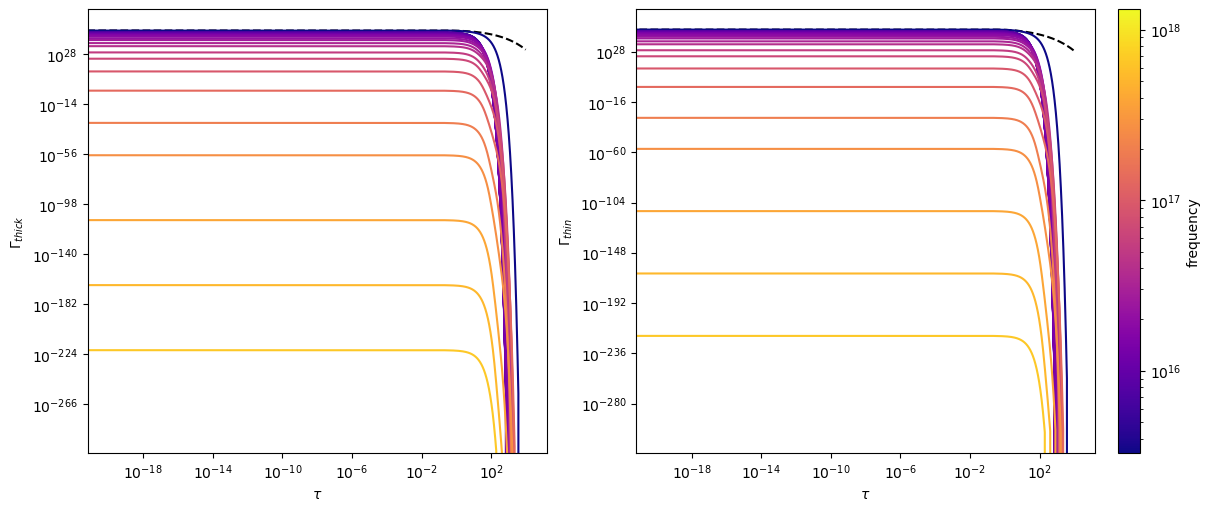

In [36]:
import matplotlib

# old BB
r1 = pc2r.BlackBodySource(temp=5e4, grey=False, freq0=freq_HI, pl_index=2.8)
photo_thin_table, photo_thick_table = r1.make_photo_table(tau, freq_min, freq_max, 1e48)

# new BB
r2 = BlackBodySource_Multifreq(temp=5e4, freq0_HI=freq0_HI, freq0_HeI=freq0_HeI, freq0_HeII=freq0_HeII, grey=False)
photo_thin_table2, photo_thick_table2 = r2.make_photo_table(tau, freq_min, freq_max, 1e48)

norm = matplotlib.colors.LogNorm(vmin=freq_min, vmax=freq_max, clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap='plasma')
sm = plt.cm.ScalarMappable(cmap=mapper.cmap, norm=norm)

# plot compare
fig, axs = plt.subplots(figsize=(12, 5), ncols=2, nrows=1, constrained_layout=True)
axs[0].loglog(tau, photo_thick_table, color='black', ls='--')

for i in range(photo_thick_table2.shape[0]):
    f = r2.freqs_tab[i]
    axs[0].loglog(tau, photo_thick_table2[i,:], color=mapper.to_rgba(f), ls='-')
axs[0].set_ylabel(r'$\Gamma_{thick}$')

axs[1].loglog(tau, photo_thin_table, color='black', ls='--')
for i in range(photo_thin_table2.shape[0]):
    f = r2.freqs_tab[i]
    axs[1].loglog(tau, photo_thin_table2[i,:], color=mapper.to_rgba(f), ls='-')
axs[1].set_ylabel(r'$\Gamma_{thin}$')

cbar = plt.colorbar(sm, ax=axs[1], label='frequency')

for ax in axs:
    ax.set_xlabel(r'$\tau$')